In [1]:
import numpy as np
import pandas as pd
import glob
from model.ctabgan import CTAB_XTRA_DP
df = pd.read_csv("datasets/adult.csv")
df = df.head(10000)

In [2]:
age = df['age']

In [3]:
age.describe()

count    10000.00000
mean        38.75330
std         13.87222
min         17.00000
25%         28.00000
50%         37.00000
75%         48.00000
max         90.00000
Name: age, dtype: float64

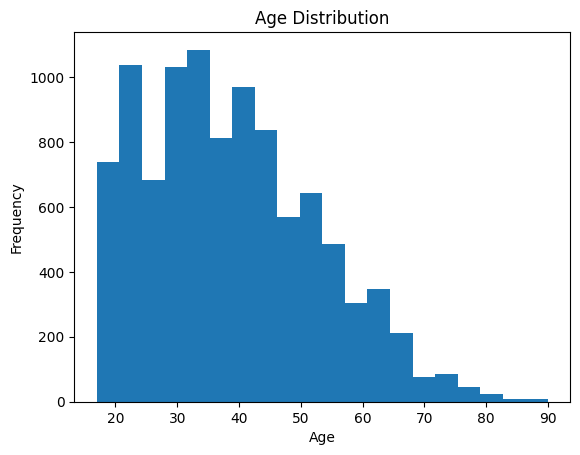

In [4]:
import matplotlib.pyplot as plt

age.plot(kind='hist', bins=20, title='Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

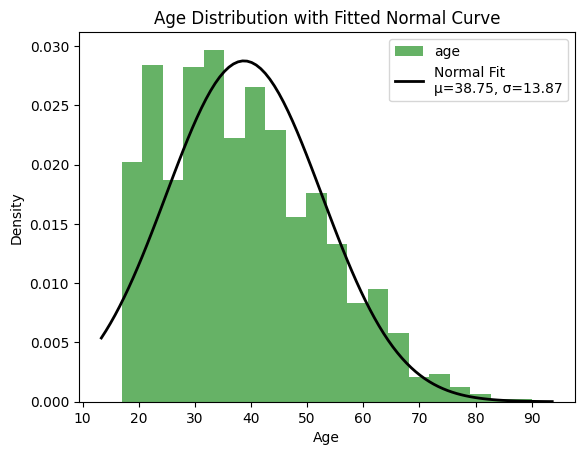

(np.float64(38.7533), np.float64(13.871526199737358))

In [5]:
from scipy.stats import norm

# Fit a normal distribution to the age data
mu, std = norm.fit(age)

# Plot the histogram of the age data with the fitted normal distribution
age.plot(kind='hist', bins=20, density=True, alpha=0.6, color='g', title='Age Distribution with Fitted Normal Curve')

# Plot the PDF of the fitted normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label=f'Normal Fit\nμ={mu:.2f}, σ={std:.2f}')

plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

mu, std

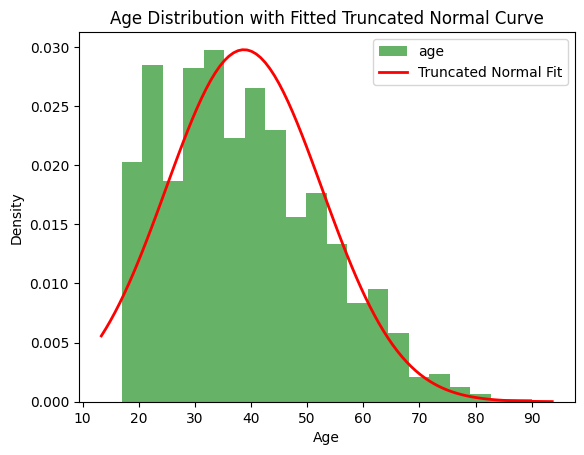

In [6]:
from scipy.stats import truncnorm

# Define the bounds for the truncated normal distribution
a, b = (xmin - mu) / std, (xmax - mu) / std

# Fit the truncated normal distribution
trunc_norm_dist = truncnorm(a, b, loc=mu, scale=std)

# Generate the PDF of the fitted truncated normal distribution
x_trunc = np.linspace(xmin, xmax, 100)
p_trunc = trunc_norm_dist.pdf(x_trunc)

# Plot the histogram of the age data with the fitted truncated normal distribution
age.plot(kind='hist', bins=20, density=True, alpha=0.6, color='g', title='Age Distribution with Fitted Truncated Normal Curve')

plt.plot(x_trunc, p_trunc, 'r', linewidth=2, label='Truncated Normal Fit')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
# Calculate the mean of the truncated normal distribution
trunc_mean = trunc_norm_dist.mean()

# Plot the mean on the histogram with the fitted truncated normal distribution
age.plot(kind='hist', bins=20, density=True, alpha=0.6, color='g', title='Age Distribution with Truncated Normal Mean')

plt.plot(x_trunc, p_trunc, 'r', linewidth=2, label='Truncated Normal Fit')
plt.axvline(trunc_mean, color='b', linestyle='--', linewidth=2, label=f'Truncated Mean: {trunc_mean:.2f}')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

Truncated Normal Distribution Mean (μ): nan
Truncated Normal Distribution Standard Deviation (σ): nan


In [7]:
from sklearn.metrics import mean_squared_error

# Calculate the histogram of the age data
hist, bin_edges = np.histogram(age, bins=100, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the MSE for the normal distribution fit
mse_normal = mean_squared_error(hist, norm.pdf(bin_centers, mu, std))

# Calculate the MSE for the truncated normal distribution fit
mse_trunc = mean_squared_error(hist, trunc_norm_dist.pdf(bin_centers))

print(f"Mean Squared Error (Normal Distribution): {mse_normal:.6f}")
print(f"Mean Squared Error (Truncated Normal Distribution): {mse_trunc:.6f}")

Mean Squared Error (Normal Distribution): 0.000125
Mean Squared Error (Truncated Normal Distribution): 0.000125


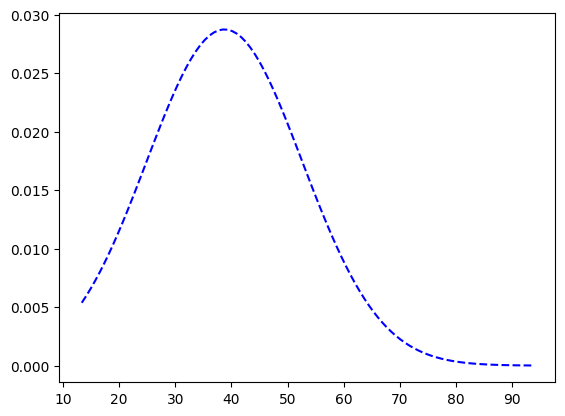

In [8]:
from scipy.stats import norm

# Normal fit (for comparison)
norm_dist = norm(loc=mu, scale=std)
p_norm = norm_dist.pdf(x_trunc)

plt.plot(x_trunc, p_norm, 'b--', label='Full Normal Fit')


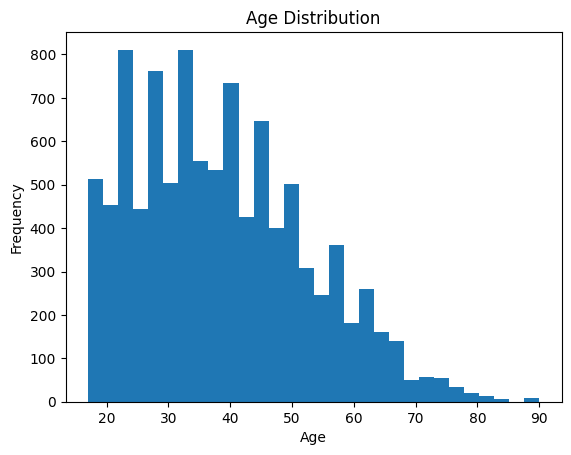

In [9]:
age.plot(kind='hist', bins=30, title='Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from scipy.optimize import minimize

def fit_truncated_normal(data, lower_cutoff = None, upper_cutoff = None):
    if lower_cutoff is None:
        lower_cutoff = data.min()
    if upper_cutoff is None:
        upper_cutoff = data.max()
    
    truncated_data = data[(data >= lower_cutoff) & (data <= upper_cutoff)]
    init_guess = [np.mean(truncated_data), np.std(truncated_data)]
    result = minimize(
        neg_log_likelihood_two_sided,
        x0=init_guess,
        args=(truncated_data, lower_cutoff, upper_cutoff),
        bounds=[(None, None), (1e-5, None)],
        method='L-BFGS-B'
    )
    mu, sigma = result.x
    return mu, sigma






def neg_log_likelihood_two_sided(params, data, a, b):
    mu, sigma = params
    if sigma <= 0:
        return np.inf
    z = (data - mu) / sigma
    alpha = (a - mu) / sigma
    beta = (b - mu) / sigma
    logpdf = norm.logpdf(z)
    trunc_logprob = np.log(norm.cdf(beta) - norm.cdf(alpha))
    ll = np.sum(logpdf) - len(data) * np.log(sigma) - len(data) * trunc_logprob
    return -ll


def truncated_normal_to_unit(x, mu, sigma, a, b):
    Fa = norm.cdf((a - mu) / sigma)
    Fb = norm.cdf((b - mu) / sigma)
    Fx = norm.cdf((x - mu) / sigma)
    return (Fx - Fa) / (Fb - Fa)






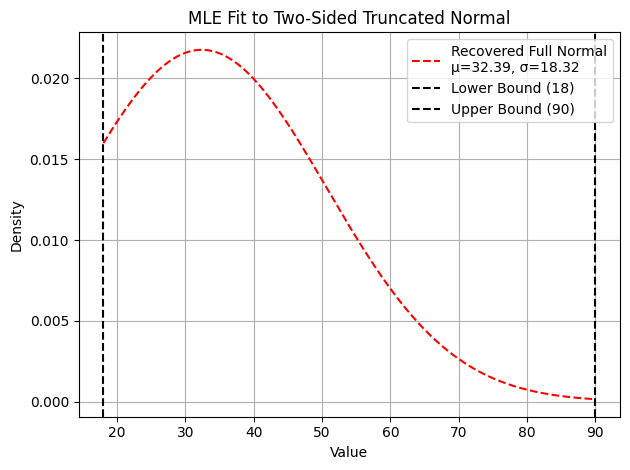

(np.float64(32.38503057391979), np.float64(18.322398517608995))

In [ ]:
# Let's now simulate two-sided truncation: 40 ≤ X ≤ 65

# Step 1: Use the same full data from a normal distributio

# Step 2: Truncate data between 40 and 65
lower_cutoff = 17
upper_cutoff = 90

result = fit_truncated_normal(age)
mu_mle, sigma_mle = result

# Step 5: Plot




def plot_truncated_normal_fit(lower_cutoff, upper_cutoff, mu_mle, sigma_mle):
    x = np.linspace(lower_cutoff, upper_cutoff, 500)
    pdf_mle = norm.pdf(x, loc=mu_mle, scale=sigma_mle)
    #plt.hist(data, bins=40, density=True, alpha=0.5, label="Observed Truncated Data")
    plt.plot(x, pdf_mle, 'r--', label=f"Recovered Full Normal\nμ={mu_mle:.2f}, σ={sigma_mle:.2f}")

    plt.axvline(lower_cutoff, color='k', linestyle='--', label=f"Lower Bound ({lower_cutoff})")
    plt.axvline(upper_cutoff, color='k', linestyle='--', label=f"Upper Bound ({upper_cutoff})")
    plt.title("MLE Fit to Two-Sided Truncated Normal")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_truncated_normal_fit(lower_cutoff, upper_cutoff, mu_mle, sigma_mle)

(mu_mle, sigma_mle)


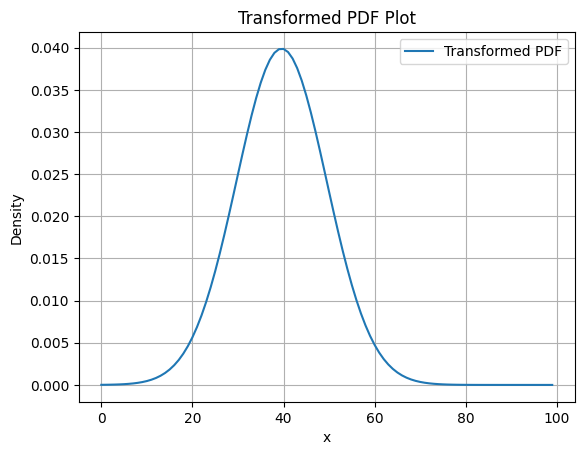

In [267]:
# Recreate x and mock mu_mle, sigma_mle if needed for demonstration
x = np.linspace(0, 100, 100)

# For demonstration, define example mu and sigma
mu_mle = 40
sigma_mle = 10
lower_cutoff = 20
upper_cutoff = 90



# Use the transformation function again
def truncated_normal_to_unit(x, mu, sigma, a, b):
    Fa = norm.cdf((a - mu) / sigma)
    Fb = norm.cdf((b - mu) / sigma)
    Fx = norm.cdf((x - mu) / sigma)
    return (Fx - Fa) / (Fb - Fa)


area = norm.cdf(upper_cutoff, loc=mu_mle, scale=sigma_mle) - norm.cdf(lower_cutoff, loc=mu_mle, scale=sigma_mle)
x = (x + norm.cdf(lower_cutoff, loc=mu_mle, scale=sigma_mle))


plt.plot(norm.pdf(x, loc=mu_mle, scale=sigma_mle), label='Transformed PDF')
plt.title('Transformed PDF Plot')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()





In [87]:
from scipy.stats import norm

# Parameters of the normal distribution
mu = 50  # Mean
sigma = 10  # Standard deviation

# Point at which to calculate the CDF
x = 20

# Calculate F(x)
F_x = norm.cdf(x, loc=mu, scale=sigma)
print(f"F({x}) = {F_x}")

F(20) = 0.001349898031630093


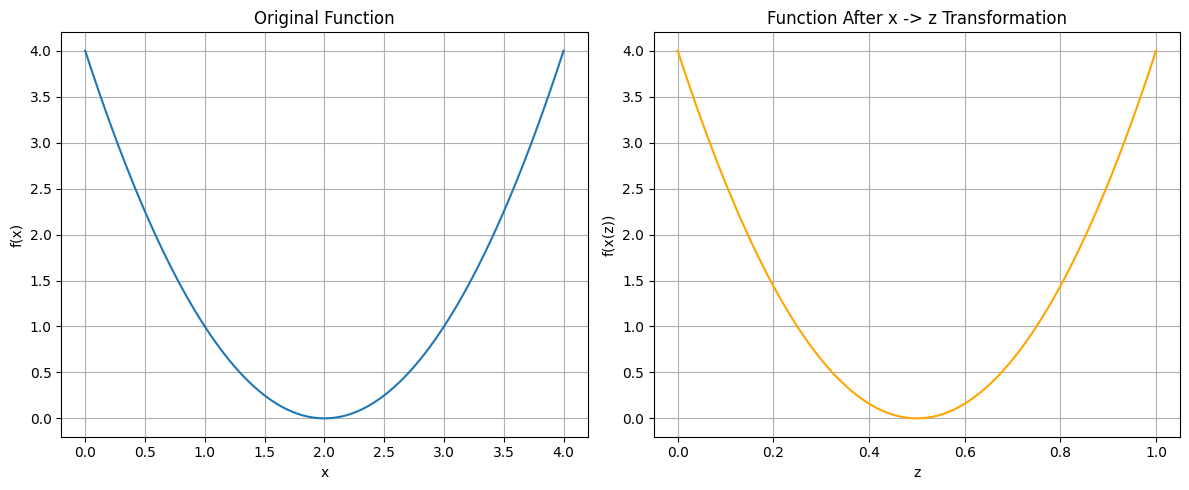

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Original function: let's say it's a quadratic between a and b
def original_function(x):
    return (x - 2) ** 2

# Normalization and denormalization
def normalize(x, a, b):
    return (x - a) / (b - a)

def denormalize(z, a, b):
    return z * (b - a) + a

# Define range
x_vals = np.linspace(0, 4, 100)
y_vals = original_function(x_vals)

# Apply transformation: normalize x values to z in [0, 1]
a, b = 0, 4
z_vals = normalize(x_vals, a, b)


# Plot both original and transformed
plt.figure(figsize=(12, 5))

# Original plot
plt.subplot(1, 2, 1)
plt.plot(x_vals, y_vals, label='Original f(x)')
plt.title('Original Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)

# Transformed plot
plt.subplot(1, 2, 2)
plt.plot(z_vals, y_vals, label='Transformed f(z)', color='orange')
plt.title('Function After x -> z Transformation')
plt.xlabel('z')
plt.ylabel('f(x(z))')
plt.grid(True)

plt.tight_layout()
plt.show()
